In [ ]:
source("../00_model-fitting/wwa_model-fitting.R")

---
# **99th %ile of FWI (EJB)**

## **Nonstationary GEV**

In [2]:
df <- merge(read.csv("data/fwi99_EJB.csv")[,-1],
            load_ts("ts/drc-rw-floods_gmst-smoothed.dat", col.names = c("year", "gmst")))
df <- df[df$year > 1940,]   # this year looks very low - possibly due to absence of antecedent data?
gmst_2023 = df$gmst[df$year == 2023]
fwi_2023 = df$FWI99[df$year == 2023]

Warning message in file(file, "rt"):
“cannot open file 'ts/drc-rw-floods_gmst-smoothed.dat': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


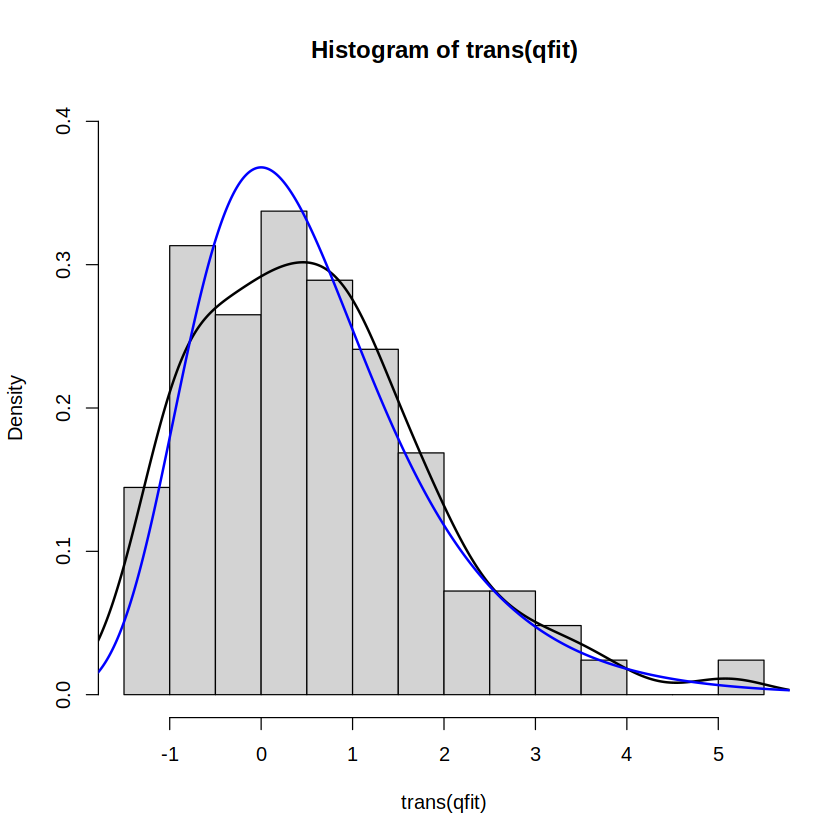

In [3]:
# check GEV fit to data
qfit <- fevd(FWI99, df, location.fun = ~gmst)

hist(trans(qfit), breaks = "fd", prob = T, ylim = c(0,0.4))
lines(density(trans(qfit)), lwd = 2)
lines(seq(-3,15,0.01), devd(seq(-3,15,0.01)), col = "blue", lwd = 2)

In [4]:
# fit candidate models
fwi99_gev <- fit_ns("gev", "shift", df, "FWI99", "gmst", lower = F)

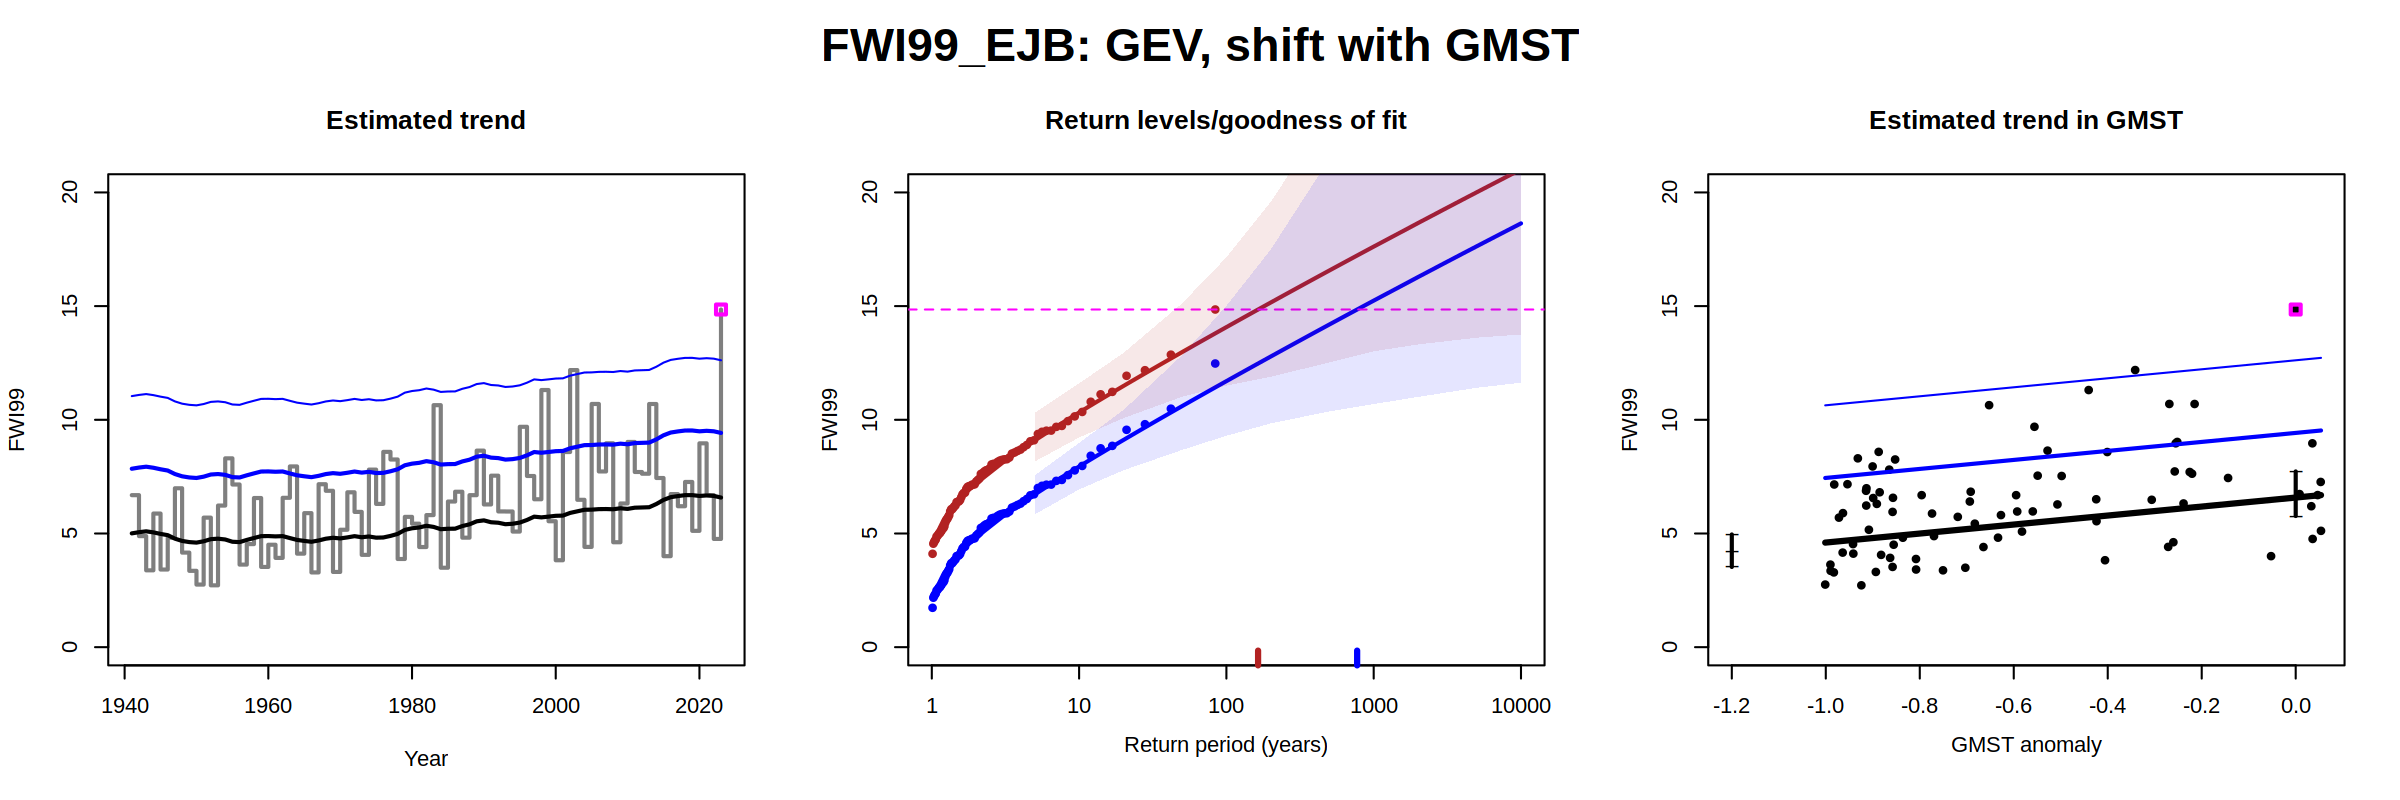

In [5]:
prep_window(c(1,3))
# png("fig/fwi99_ejb_shift-included.png", height = 480, width = 480 * 3); par(mfrow = c(1,3), cex = 1.4); {
    
    par(oma = c(0,0,2.5,0))
    plot_trend(fwi99_gev, legend_pos = NA, ylim = c(0,20), main = "Estimated trend")
    plot_returnlevels(fwi99_gev, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, nsamp = 500, ylim = c(0,20), main = "Return levels/goodness of fit")
    plot_gmsttrend(fwi99_gev, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, ylim = c(0,20), main = "Estimated trend in GMST")
    mtext("FWI99_EJB: GEV, shift with GMST", outer = T, line = 0, font = 2, cex = 1.4)    

# }; dev.off()

In [6]:
boot_ci(fwi99_gev, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ev = fwi99_gev$ev)

,bestimate,2.5%,97.5%
mu0,6.58059,5.76970,7.73949
sigma0,1.69472,1.38543,1.95045
alpha,1.97946,0.94777,3.39451
shape,-0.01724,-0.17657,0.19161
disp,0.25753,0.20879,0.29201
event_magnitude,14.85063,14.85063,14.85063
return_period,164.10186,45.18232,33773.44891
PR,4.70442,1.60141,Inf
dI_abs,2.37535,1.13732,4.07341
dI_rel,19.04046,8.29363,37.79707


---
### **Leave-one-out sensitivity analysis**

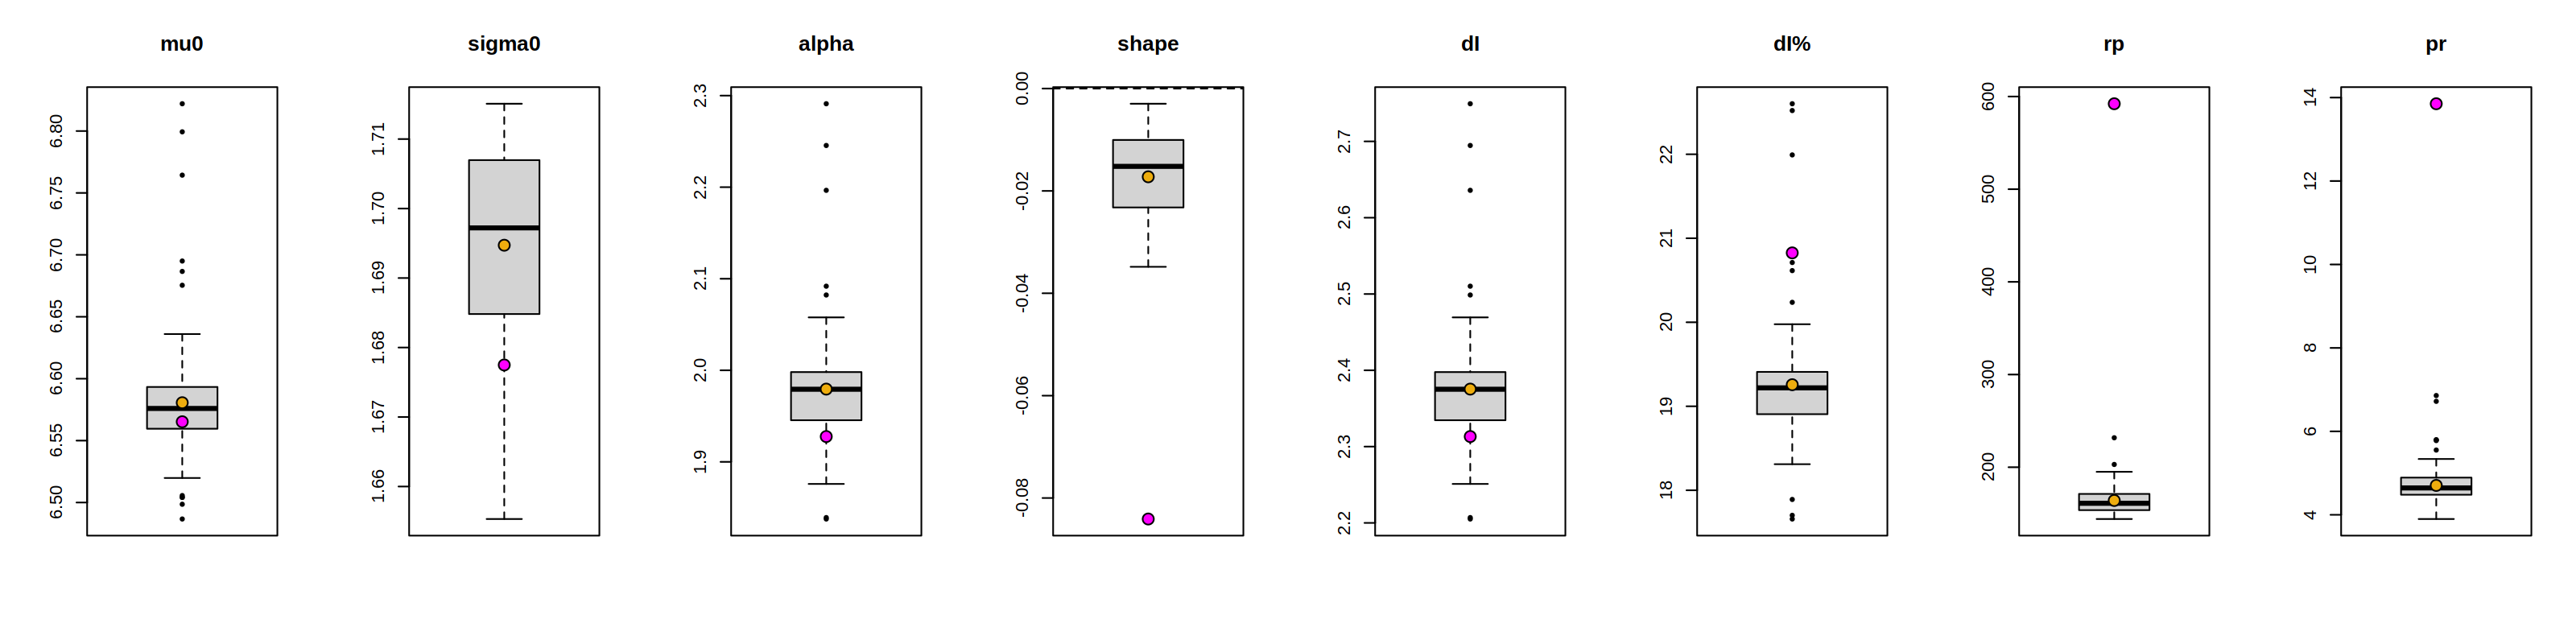

In [7]:
loo_pars(fwi99_gev, rp = 150, cov = gmst_2023, cov_cf = gmst_2023 - 1.2)

In [ ]:
# prep_window(c(1,nrow(loo_res)), w = 2)

# png("fig/fwi99-robustness.png", height = 480, width = 480 * nrow(loo_res) / 2); par(mfrow = c(1,nrow(loo_res)), cex = 1.4, pch = 20); {
#     invisible(sapply(1:nrow(loo_res), function(i) {
#         boxplot(loo_res[i,-1], main = rownames(loo_res)[i])
#         points(loo_res[i,1], pch = 21, bg = "darkgoldenrod2", cex = 1.4)
#         points(loo_res[i,ncol(loo_res)], pch = 21, bg = "magenta", cex = 1.4)   # value if 2023 event omitted
#     }))
#     mtext("Effect on parameter estimates when removing each year in turn; full dataset highlighted in gold, 2023 highlighted in pink", outer = T, side = 1, line = -3, font = 2, cex = 2)
# }; dev.off()

---
### **Bayesian model fitting**

In [1]:
source("../00_model-fitting/wwa_model-fitting.R")

df <- merge(read.csv("data/fwi99_EJB.csv")[,-1],
            load_ts("ts/drc-rw-floods_gmst-smoothed.dat", col.names = c("year", "gmst")))
df <- df[df$year > 1940,]   # this year looks very low - possibly due to absence of antecedent data?
gmst_2023 = df$gmst[df$year == 2023]
fwi_2023 = df$FWI99[df$year == 2023]

# Does Bayesian parameter estimation help?
fwi_gev_mle <- fevd(FWI99, df, location.fun = ~gmst, method = "MLE")
fwi_gev_mcmc <- fevd(FWI99, df, location.fun = ~gmst, method = "Bayesian")
fwi_gev <- fit_ns("gev", "shift", df, "FWI99", "gmst", lower = F)

# covariate matrices
qc_2023 <- make.qcov(fwi_gev_mcmc, vals = list("mu1" = gmst_2023))
qc_pi <- make.qcov(fwi_gev_mcmc, vals = list("mu1" = gmst_2023 - 1.2))

In [2]:
# check that my estimate matches the extRemes estimate
strip(fwi_gev_mle)[c(1,3,2,4)]
fwi_gev$par

mu0       scale         mu1       shape 
 6.58024256  1.69479037  1.97886917 -0.01732112

mu0      sigma0       alpha       shape 
 6.58059251  1.69472082  1.97945861 -0.01723926

In [3]:
mle_pars <- strip(fwi_gev_mle)
mcmc_pars <- strip(fwi_gev_mcmc)

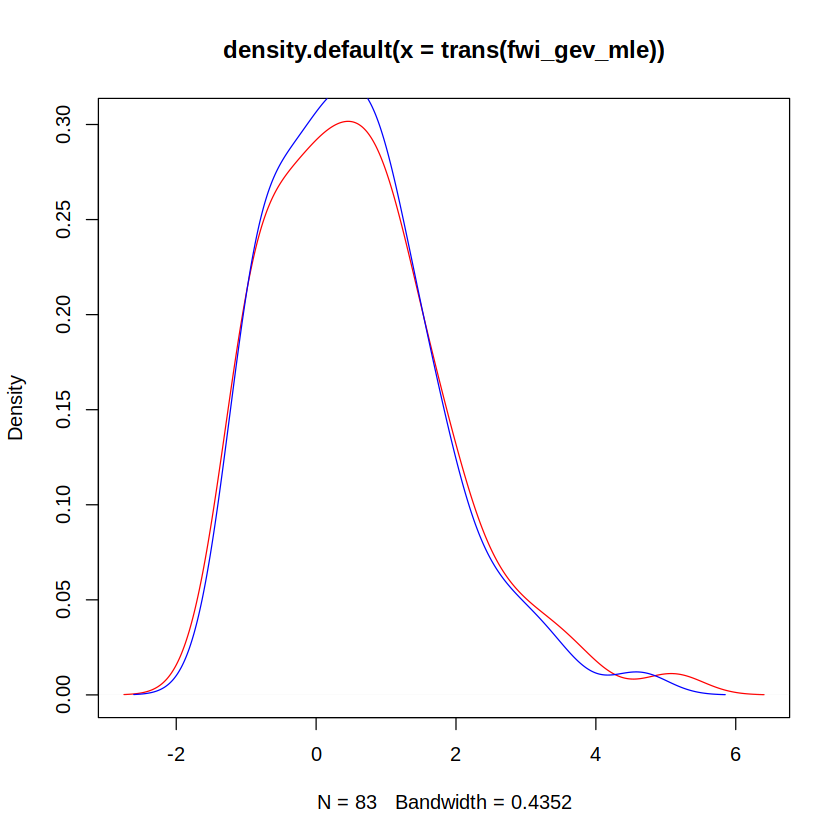

In [4]:
plot(density(trans(fwi_gev_mle)), col = "red")
lines(density(trans(fwi_gev_mcmc)), col = "blue")

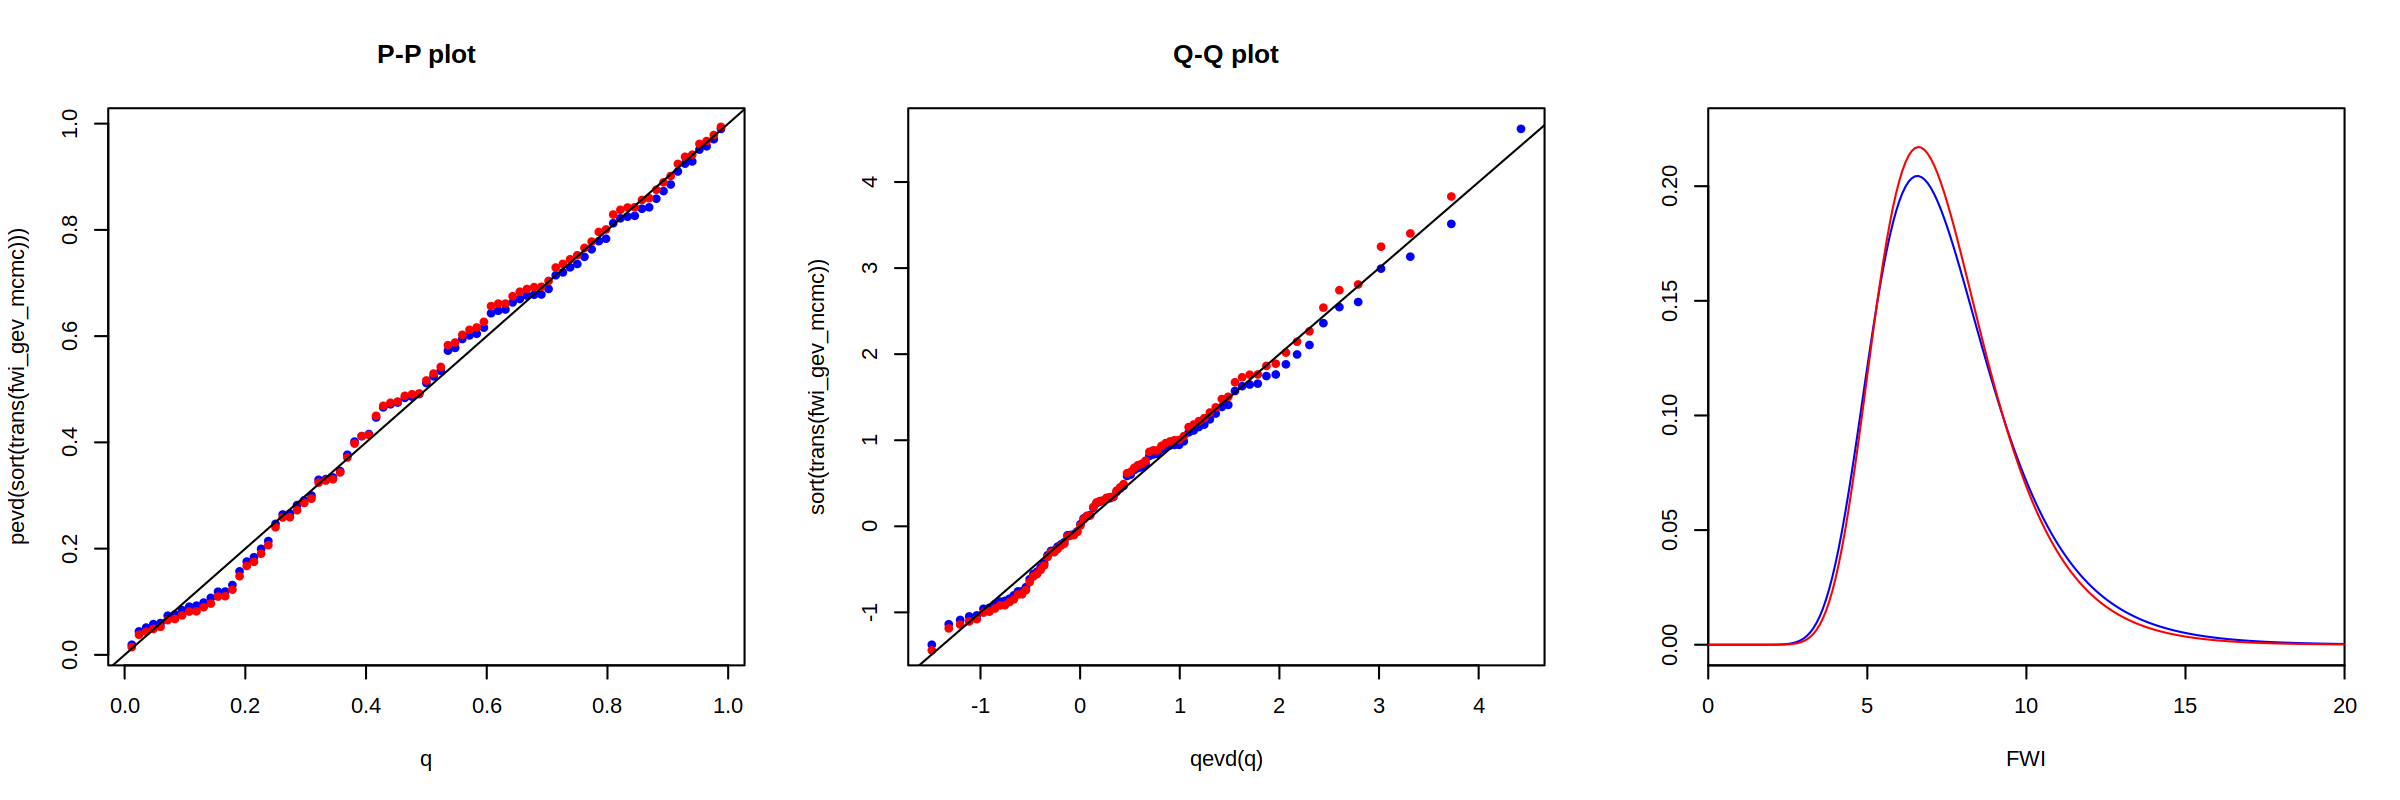

In [5]:
prep_window(c(1,3))
q <- seq(0,1,length.out = nrow(df)+2)[2:84]
plot(q, pevd(sort(trans(fwi_gev_mcmc))), col = "blue", main = "P-P plot")
points(q, pevd(sort(trans(fwi_gev_mle))), col = "red")

abline(0,1)

plot(qevd(q), sort(trans(fwi_gev_mcmc)), col = "blue", main = "Q-Q plot")
points(qevd(q), sort(trans(fwi_gev_mle)), col = "red")
abline(0,1)

# quite different tail behaviour. MLE seems to give better fit in body, but maybe not in the very tail?
x <- seq(0,20,0.1)

plot(x, devd(x, loc = mcmc_pars["mu0"], scale = mcmc_pars["scale"], shape = mcmc_pars["shape"]), type = "l", xlab = "FWI", ylab = "", col = "blue", ylim = c(0,0.225), xaxs = "i")
lines(x, devd(x, loc = mle_pars["mu0"], scale = mle_pars["scale"], shape = mle_pars["shape"]), col = "red")

In [8]:
return_period(fwi_gev, fwi_gev$ev, fixed_cov = gmst_2023)   # round to 150

[1] 164.1019

In [9]:
rl_2023 <- ci.fevd(fwi_gev_mcmc, type = "return.level", return.period = 150, qcov = qc_2023)[2]
rl_pi <- ci.fevd(fwi_gev_mcmc, type = "return.level", return.period = 150, qcov = qc_pi)[2]

dI = rl_2023 - rl_pi
dI_rel <- (rl_2023 - rl_pi) / rl_pi * 100

rp_2023 <- 1/(1-pextRemes(fwi_gev_mcmc, df$FWI99[df$year == 2023], qcov = qc_2023))
rp_pi <- 1/(1-pextRemes(fwi_gev_mcmc, df$FWI99[df$year == 2023], qcov = qc_pi))
pr = rp_pi / rp_2023

mcmc_res <- c(strip(fwi_gev_mcmc)[c("mu0", "scale", "mu1", "shape")], "dI" = dI, "dI%" = dI_rel, "rp" = rp_2023, "pr" = pr)

In [10]:
loo_mcmc <- sapply(1:nrow(df), function(i) {
        fit_i <- update(fwi_gev_mcmc, data = df[-i,])
        
        rl_2023 <- ci.fevd(fit_i, type = "return.level", return.period = 150, qcov = qc_2023)[2]
        rl_pi <- ci.fevd(fit_i, type = "return.level", return.period = 150, qcov = qc_pi)[2]

        dI = rl_2023 - rl_pi
        dI_rel <- (rl_2023 - rl_pi) / rl_pi * 100

        rp_2023 <- 1/(1-pextRemes(fit_i, df$FWI99[df$year == 2023], qcov = qc_2023))
        rp_pi <- 1/(1-pextRemes(fit_i, df$FWI99[df$year == 2023], qcov = qc_pi))
        pr = rp_pi / rp_2023
        
        c(strip(fit_i)[c("mu0", "scale", "mu1", "shape")], "dI" = dI, "dI%" = dI_rel, "rp" = rp_2023, "pr" = pr)
    })
loo_mcmc <- cbind("all_years" = mcmc_res, loo_mcmc)

In [11]:
loo_mle <- loo_pars(fwi_gev, rp = 150, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, plot = F)

In [25]:
prep_window(c(1,9), w = 2)

png("fig/fwi99_parameter-robustness.png", height = 480, width = 480*4.5); par(mfrow = c(1,9), cex = 1.4, pch = 20); {

    par(oma = c(0,0,2,0), mar = c(1,3,3,1))
    invisible(sapply(1:nrow(loo_mle), function(i) {

        ylim = range(loo_mle[i,][is.finite(loo_mle[i,])], loo_mcmc[i,][is.finite(loo_mcmc[i,])])
        boxplot(loo_mle[i,-1], main = rownames(loo_mle)[i], ylim = ylim, col = adjustcolor("red", alpha = 0.3), border = "red3", cex = 0.75)
        boxplot(loo_mcmc[i,-1], add = T, col = adjustcolor("blue", alpha = 0.3), border = "blue", cex = 0.75)
        points(loo_mle[i,1], pch = 21, bg = "gold", col = "black", lwd = 2)
        points(loo_mle[i,which(df$year == 2023)+1], pch = 21, bg = "magenta", col = "black", lwd = 2)
        points(loo_mcmc[i,1], pch = 21, bg = "turquoise", col = "black", lwd = 2)
        points(loo_mcmc[i, which(df$year == 2023)+1], pch = 21, bg = "blue", col = "black", lwd = 2)
        if(rownames(loo_mle)[i] == "pr") { abline(h = 1, lty = 2) } else { abline(h = 0, lty = 2) }
    }))
    par(mar = c(1,0,3,1))
    plot.new()
    legend("left", bty = "n", legend = c("All years\n(MLE)\n", "2023 omitted\n(MLE)\n", "All years\n(MCMC)\n", "2023 omitted\n(MCMC)\n"),
           pch = 21, pt.bg = c("gold", "magenta", "turquoise", "blue"), col = "black", lwd = 2, lty = NA)
    mtext("Leave-one-out evaluation of robustness of MLE (red) and Bayesian (blue) parameter estimates", outer = T, side = 3, font = 2, cex = 1.5)
}; dev.off()

png 
  2

## **Contributions of subindices to FWI**

In [8]:
rnm <- "EJB"
stat <- "mean"
df <- merge(merge(load_ts("ts/drc-rw-floods_gmst-smoothed.dat", col.names = c("year", "gmst")),
                  read.csv(paste0("data/FWI99/fwi99_", rnm,".csv"), col.names = c("x", "year", "fwi99")))[-1,],
            Reduce(function(x, y) merge(x, y, all=TRUE), sapply(c('isi','bui','ffmc','dmc','dc'), 
                                                                function(v) read.csv(paste0("subindices/",v,"_",stat,"_",rnm,".csv"), col.names = c("x", "year", v))[,-1], simplify = F)))                                     
df <- df[df$year > 1940,]

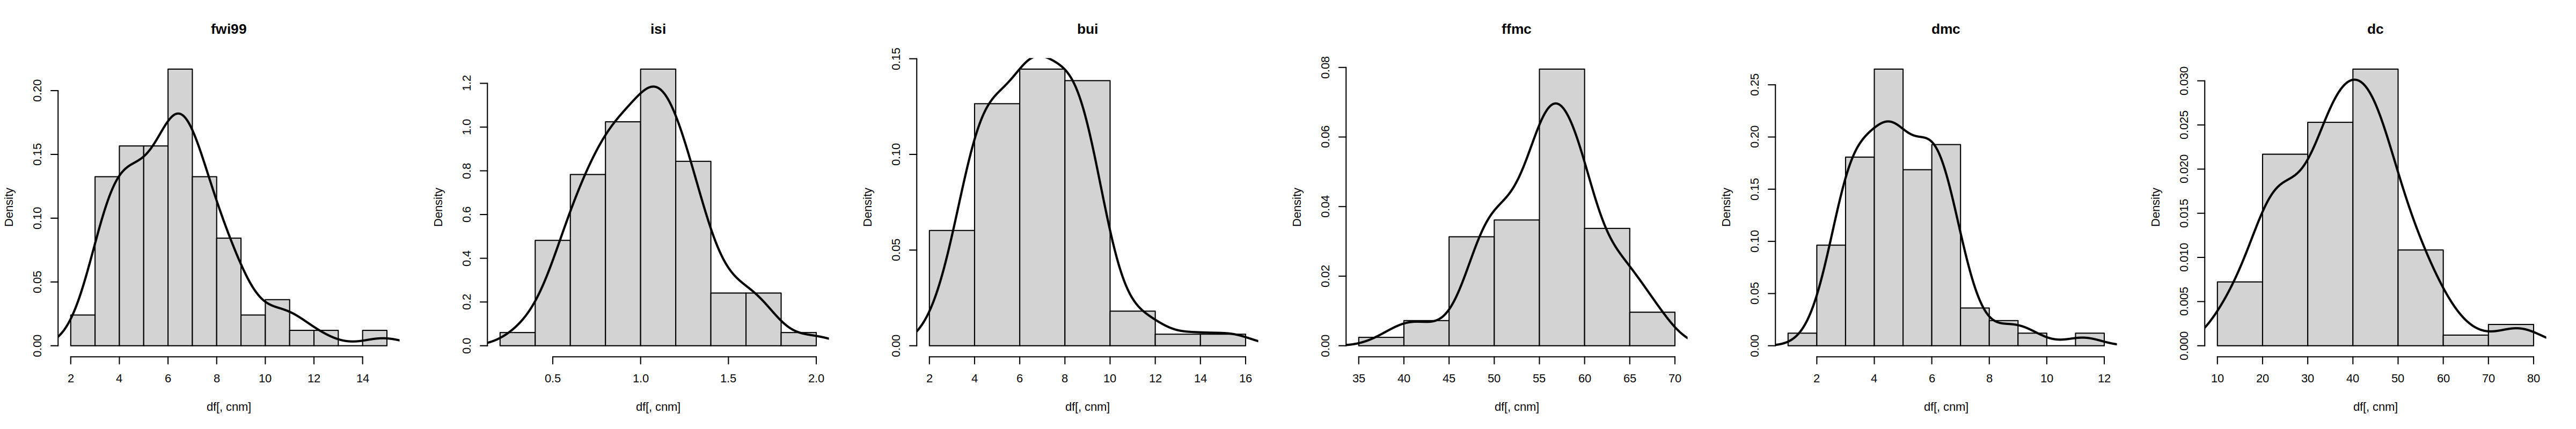

In [9]:
prep_window(c(1,6))
invisible(sapply(colnames(df)[-(1:3)], function(cnm) {
    
    hist(df[,cnm], breaks = "fd", prob = T, main = cnm)
    lines(density(df[,cnm]), lwd = 2)
    
}))

In [10]:
mdl_fwi99 <- fit_ns("gev", "shift", df, "fwi99", "gmst", lower = F)
mdl_ffmc <- fit_ns("norm", "shift", df, "ffmc", "gmst", lower = F)
mdl_bui <- fit_ns("gev", "shift", df, "bui", "gmst", lower = F)
mdl_dc <- fit_ns("gev", "fixeddisp", df, "dc", "gmst", lower = F)
mdl_dmc <- fit_ns("gev", "fixeddisp", df, "dmc", "gmst", lower = F)
mdl_isi <- fit_ns("norm", "fixeddisp", df, "isi", "gmst", lower = F)

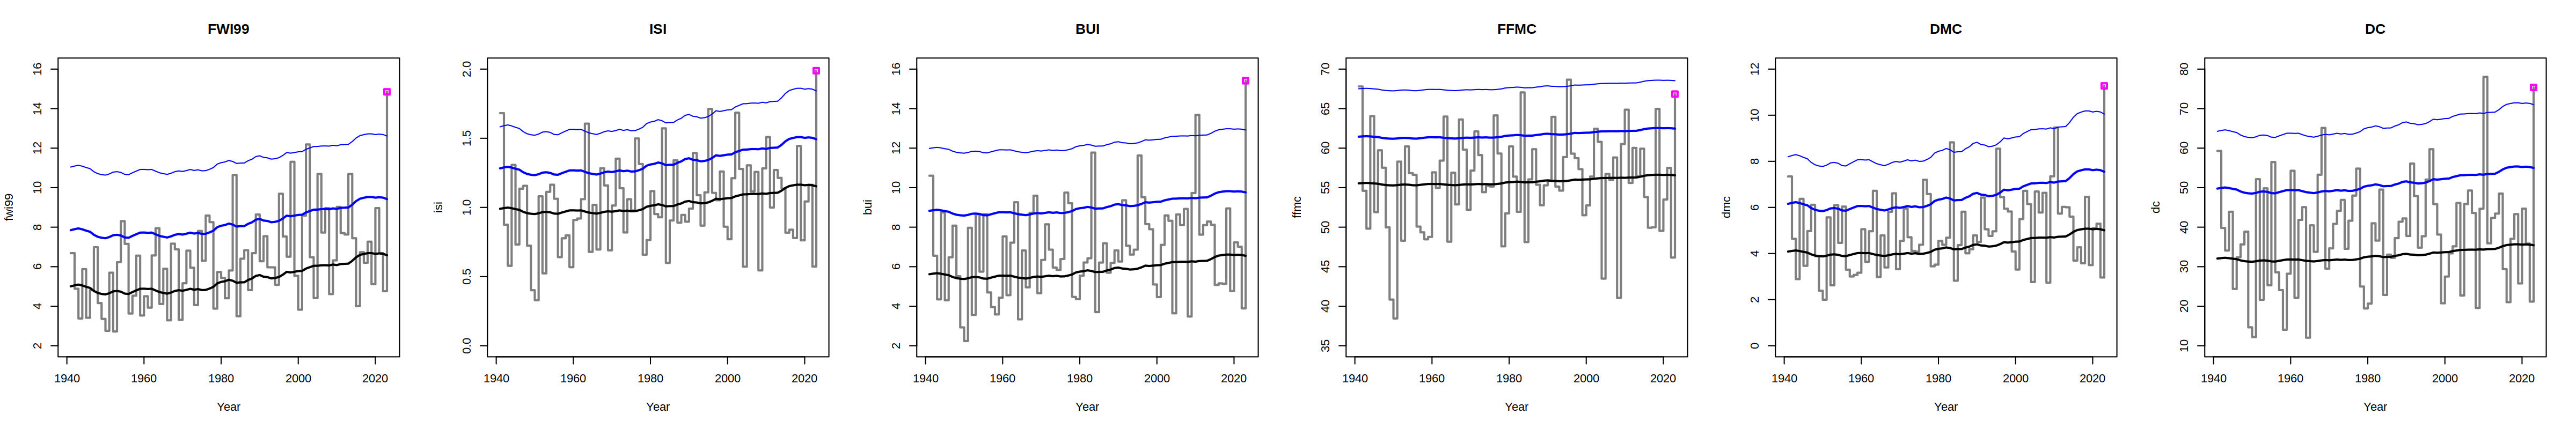

In [11]:
prep_window(c(1,6))
invisible(sapply(colnames(df)[-(1:3)], function(cnm) plot_trend(get(paste0("mdl_",cnm)), legend_pos = NA, main = toupper(cnm))))

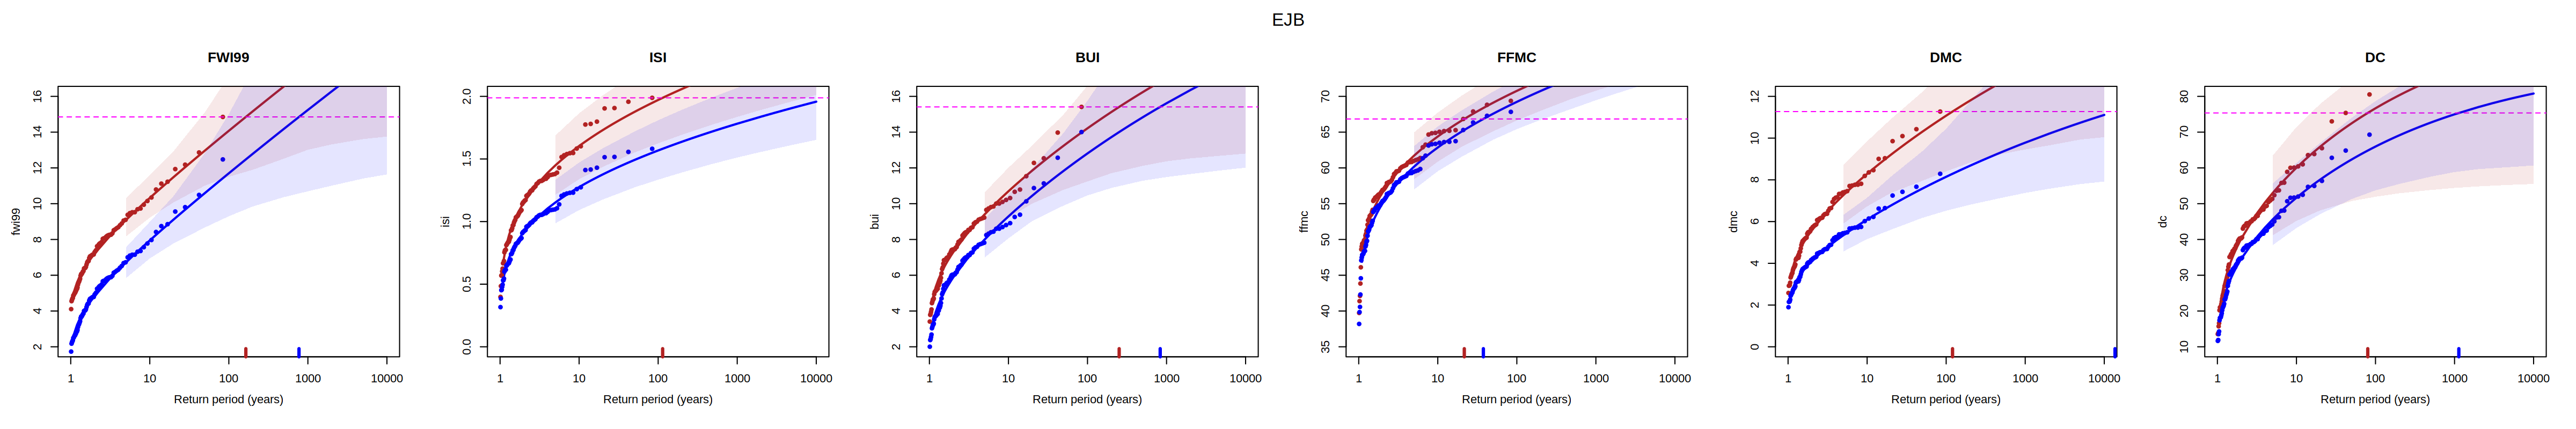

In [12]:
prep_window(c(1,6)); par(oma = c(0,0,2,0))
invisible(sapply(colnames(df)[-(1:3)], function(cnm) plot_returnlevels(get(paste0("mdl_",cnm)), cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, main = toupper(cnm))))
mtext(rnm, outer = T)

In [ ]:
prep_window(c(1,5))

# png(paste0("fig/climate-trends_",rnm,".png"), height = 480, width = 480 * 4); par(mfrow = c(1,4), cex = 1.4, oma = c(0,0,2,0)); {
    
    # plot_returnlevels(mdl_fwi, cov = gmst_2023, cov_cf = gmst_2023 - 1, legend_pos = NA, main = "FWI")
    plot_returnlevels(mdl_ffmc, cov = gmst_2023, cov_cf = gmst_2023 - 1, legend_pos = NA, main = "ffmc")
    plot_returnlevels(mdl_bui, cov = gmst_2023, cov_cf = gmst_2023 - 1, legend_pos = NA, main = "bui")

    plot_returnlevels(mdl_dc, cov = gmst_2023, cov_cf = gmst_2023 - 1, legend_pos = NA, main = "dc")
    plot_returnlevels(mdl_dmc, cov = gmst_2023, cov_cf = gmst_2023 - 1, legend_pos = NA, main = "dmc")
    plot_returnlevels(mdl_isi, cov = gmst_2023, cov_cf = gmst_2023 - 1, legend_pos = NA, main = "isi")

    mtext(rnm, outer = T)

# how best to quantify relative contributions from tas & hurs, for example, given their different units?
# }; dev.off()

## **Contributions of weather indices to FWI**

In [ ]:
source("../00_model-fitting/wwa_model-fitting.R")

df <- merge(read.csv("data/fwi99_EJB.csv")[,-1],
            load_ts("ts/drc-rw-floods_gmst-smoothed.dat", col.names = c("year", "gmst")))
df <- df[df$year > 1940,]   # this year looks very low - possibly due to absence of antecedent data?
gmst_2023 = df$gmst[df$year == 2023]

In [ ]:
rnm <- "EJB"
df <- merge(merge(merge(merge(load_ts("ts/drc-rw-floods_gmst-smoothed.dat", col.names = c("year", "gmst")),
            read.csv(paste0("climate/hurs_q1_",rnm,".csv"), col.names = c("x", "year", "hurs"))[,-1]),
            read.csv(paste0("climate/tp_",rnm,".csv"), col.names = c("x", "year", "tp"))[,-1]),
            read.csv(paste0("climate/tas_q99_",rnm,".csv"), col.names = c("x", "year", "tas"))[,-1]),
            read.csv(paste0("climate/sfcWind_q99_",rnm,".csv"), col.names = c("x", "year", "sfcWind"))[,-1])

df <- df[df$year > 1940,]

In [ ]:
# mdl_fwi <- fit_ns("gev", "shift", df, "fwi99", "gmst", lower = F)
mdl_tas <- fit_ns("norm", "shift", df, "tas", "gmst", lower = F)
mdl_hurs <- fit_ns("norm", "fixeddisp", df, "hurs", "gmst", lower = T)
mdl_tp <- fit_ns("norm", "fixeddisp", df, "tp", "gmst", lower = T)
mdl_sfcWind <- fit_ns("norm", "fixeddisp", df, "sfcWind", "gmst", lower = F)

In [ ]:
prep_window(c(1,4))

png(paste0("fig/climate-trends_quantiles_",rnm,".png"), height = 480, width = 480 * 4); par(mfrow = c(1,4), cex = 1.4, oma = c(0,0,2,0)); {
    
    # plot_returnlevels(mdl_fwi, cov = gmst_2023, cov_cf = gmst_2023 - 1, legend_pos = NA, main = "FWI")
    plot_trend(mdl_tas, legend_pos = NA, main = "tas", ylim = c(14,28))
    plot_trend(mdl_hurs, legend_pos = NA, main = "hurs", ylim = c(30,60))

    plot_trend(mdl_tp, legend_pos = NA, main = "tp")
    plot_trend(mdl_sfcWind, legend_pos = NA, main = "sfcWind", ylim = c(20,36))
    
    mtext(rnm, outer = T)

# how best to quantify relative contributions from tas & hurs, for example, given their different units?
}; dev.off()

---
## **FWI_99 for all regions**

In [ ]:
sapply(gsub(".csv", "", gsub("fwi99_", "", list.files("data/FWI99")))[-(1:4)], function(rnm) {

    df <- merge(read.csv(paste0("data/FWI99/fwi99_",rnm,".csv"))[,-1],
                load_ts("ts/drc-rw-floods_gmst-smoothed.dat", col.names = c("year", "gmst")))
    df <- df[df$year > 1940,]   # first year looks very low - probably due to absence of antecedent data - so will exclude
    df <- df[!is.na(rowSums(df)),]     # remove any missing data
    
    gmst_2023 = df$gmst[df$year == 2023]
    fwi_2023 = df$FWI99[df$year == 2023]
    
    mdl <- fit_ns("gev", "shift", df, "FWI99", "gmst", lower = F)
    
    rp <- round(return_period(mdl, fwi_2023, gmst_2023))
    pr <- round(prob_ratio(mdl, fwi_2023, gmst_2023, gmst_2023 - 1.2), 1)
    dI <- round(int_change(mdl, rp + (rp == 1) * 0.1, gmst_2023, gmst_2023 - 1.2, relative = T), 1)

    # prep_window(c(1,3))
    png(paste0("fwi99_fig/fwi99-trends_",rnm,".png"), height = 480, width = 480 * 3); par(mfrow = c(1,3), cex = 1.4); {
        plot_trend(mdl, legend_pos = NA, ylim = c(0,20))
        plot_returnlevels(mdl, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, nsamp = 500, ylim = c(0,20))
        plot_gmsttrend(mdl, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, ylim = c(0,20))
        mtext(paste0("FWI99 ",rnm,": shift fit, include event (RP ", rp, "; PR ",pr, "; dI ",dI,"%)"), outer = T, line = -2.5, font = 2, cex = 2)
    }; dev.off()

    # check sensitivity of parameter estimates to individual years
    loo_res <- loo_pars(mdl, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, plot = F)
    png(paste0("fwi99_fig/fwi99-parameter-robustness_",rnm,".png"), height = 480, width = 480 * 4); par(mfrow = c(1,8), cex = 1.4); {
        invisible(sapply(row.names(loo_res), function(i) {
            boxplot(loo_res[i,-1], main = i, pch = 20)
            points(loo_res[i,1], pch = 21, bg = "darkgoldenrod2", cex = 1.4)
            points(loo_res[i,ncol(loo_res)], pch = 21, bg = "magenta", cex = 1.4)   # value if 2023 event omitted
            if(i == "pr") { abline(h = 1, lty = 2) } else { abline(h = 0, lty = 2) }
        }))
    }; dev.off()

    # save bootstrapped results
    write.csv(boot_ci(mdl, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ev = fwi_2023), paste0("res/fwi99_",rnm,"_gev-shift.csv"))
})

---
# **Cumulative DSR (EJB)**

In [83]:
df <- merge(read.csv("data/cumdsr_EJB.csv", col.names = c("X", "year", "cDSR"))[,-1],
            load_ts("ts/drc-rw-floods_gmst-smoothed.dat", col.names = c("year", "gmst")))
gmst_2023 = df$gmst[df$year == 2023]
cdsr_2023 = df$cDSR[df$year == 2023]

evfit <- fevd(cDSR, df, location.fun = ~gmst)$results$par

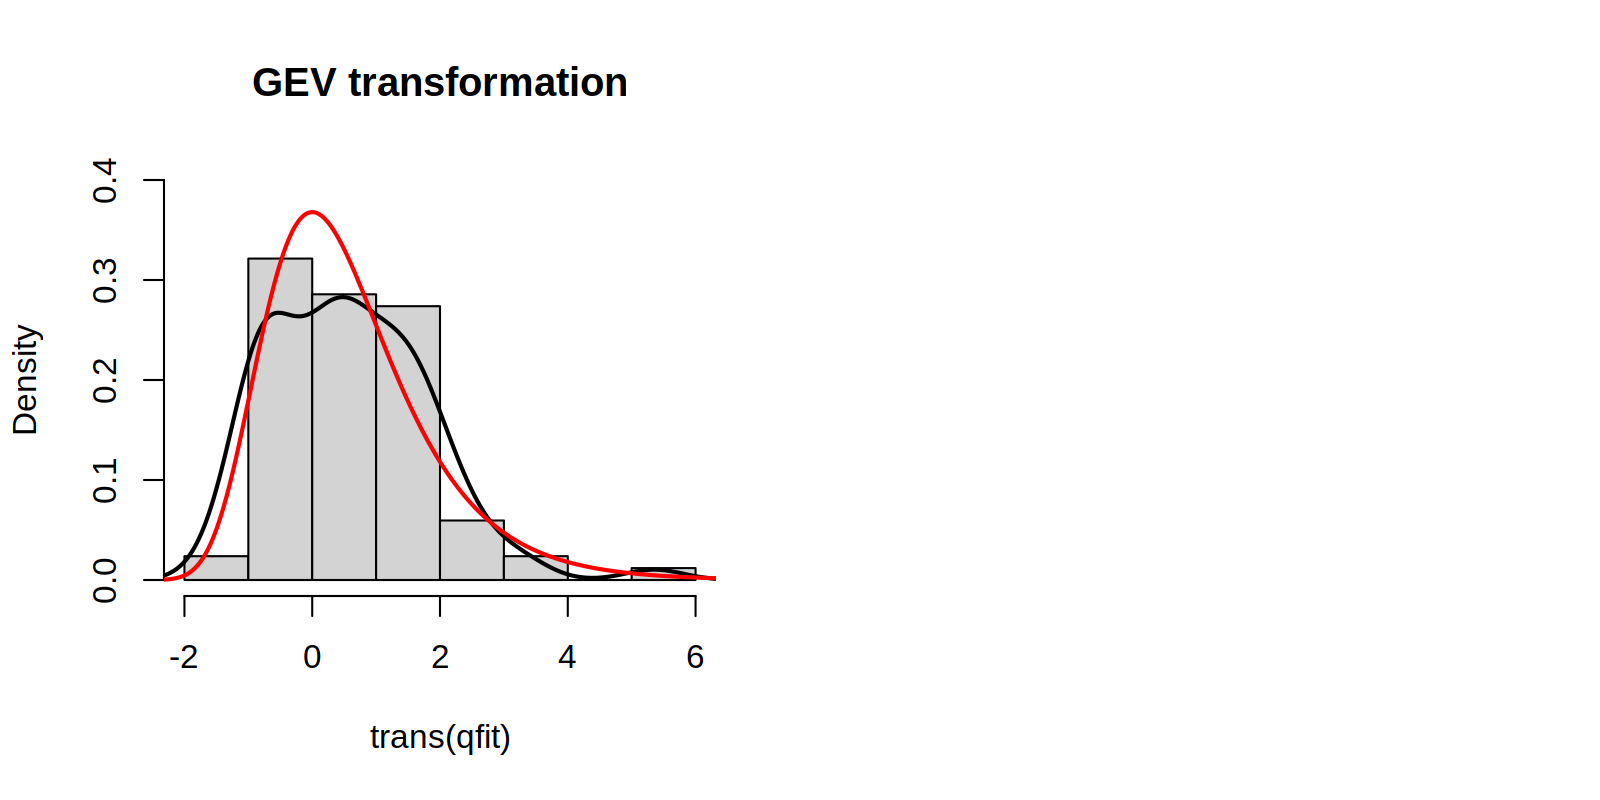

In [84]:
# quick check of GEV fit to data
qfit <- fevd(cDSR, df, location.fun = ~gmst)

prep_window(c(1,2))
hist(trans(qfit), breaks = "fd", prob = T, ylim = c(0,0.4), main = "GEV transformation")
lines(density(trans(qfit)), lwd = 2)
lines(seq(-3,15,0.01), devd(seq(-3,15,0.01)), col = "red", lwd = 2)

## **Nonstationary Gamma fitting**

In [ ]:
# nonstationary Gamma trend (both shape & rate able to vary over time)
library(MASS)

gamma_fixeddisp <- function(pars = c(shape, rate, alpha, beta), covariate, x, verbose = F) {
        
    if(verbose) print(pars)
    
    # allow both rate and shape to vary with covariate
    ns_shape = pars["shape"] * exp(pars["alpha"] * covariate)
    ns_rate = pars["rate"] * exp(pars["beta"] * covariate)
    
    # return negative log-likelihood to be minimised
    return(-sum(dgamma(x, shape = ns_shape, rate = ns_rate, log = T)))
}


fgamma <- function(x, covariate, data, method = "MLE", type = "fixeddisp", optim.method = "Nelder-Mead", init = NA, ...) {
        
    mtype <- "gamma_fixeddisp"
    
    if(is.na(init[1])) init <- c(fitdistr(data[,x], "gamma")$estimate, "alpha" = 0, "beta" = 0)
            
    # need to sort out a better way to estimate starting parameters
    res <- list("results" = suppressWarnings(optim(par = init, gamma_fixeddisp, covariate = data[,covariate], x = data[,x], method = optim.method)),
                fittype = method,
                method = optim.method, 
                type = mtype,
                x = data[,x],
                cov.data = data,
                cov.name = covariate,
                var.name = x,
                ...)
    
    return(res)
}


# alternative functions to allow variation of either rate or shape parameters, but not both
gamma_nsrate <- function(x, covariate, data, optim.method = "Nelder-Mead", verbose = F, ...) {
    
    init <- c(fitdistr(data[,x], "gamma")$estimate, "alpha" = 0)
    
    optFun <- function(pars = c(shape, rate, alpha), covariate, x, verbose = F) {
        return(-sum(dgamma(x, shape = pars["shape"], rate = pars["rate"] * exp(pars["alpha"] * covariate), log = T)))
    }
    
    # need to sort out a better way to estimate starting parameters
    res <- list("results" = suppressWarnings(optim(par = init, optFun, covariate = data[,covariate], x = data[,x], method = optim.method)),
                method = optim.method, 
                x = data[,x],
                cov.data = data,
                cov.name = covariate,
                var.name = x,
                ...)
    
    return(res)
    
}

In [ ]:
ns_gamma <- fgamma("cDSR", "year", df, optim.method = "BFGS")
s_gamma <- MASS::fitdistr(df$cDSR, "gamma")$est

nsr_gamma <- gamma_nsrate("cDSR", "year", df, optim.method = "Nelder-Mead")

# get nonstationary parameters
ns_shape = ns_gamma$results$par["shape"] * exp(ns_gamma$results$par["alpha"] * df$gmst)
ns_rate = ns_gamma$results$par["rate"] * exp(ns_gamma$results$par["beta"] * df$gmst)

nsr_rate <- nsr_gamma$results$par["rate"] * exp(nsr_gamma$results$par["alpha"] * df$gmst)

In [ ]:
hist(df$cDSR, breaks = "fd", prob = T)
lines(density(df$cDSR, from = 0), lwd = 2)
lines(seq(0,15,0.1), dgamma(seq(0,15,0.1), shape = ns_shape[80], rate = ns_rate[80]), col = "red", lwd = 2)             # nonstationary in both parameters
lines(seq(0,15,0.1), dgamma(seq(0,15,0.1), shape = s_gamma["shape"], rate = s_gamma["rate"]), col = "blue", lwd = 2)    # stationary fit
lines(seq(0,15,0.1), dgamma(seq(0,15,0.1), shape = nsr_gamma$results$par["shape"], rate = nsr_rate), col = "green", lwd = 2)        # nonstationary, changing rate only

In [ ]:
cdsr_fit <- fit_ns("gev", "shift", df, "cDSR", "gmst", lower = F)

In [ ]:
prep_window(c(1,3))
# png("fig/cdsr_ejb_gev-shift.png", height = 480, width = 480 * 3); par(mfrow = c(1,3), cex = 1.4); {
    plot_trend(cdsr_fit, legend_pos = NA, ylim = c(0,20))
    plot_returnlevels(cdsr_fit, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, nsamp = 500, ylim = c(0,20))
    plot_gmsttrend(cdsr_fit, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, ylim = c(0,20))
    mtext("cumDSR_EJB: GEV, shift with GMST", outer = T, line = -2.5, font = 2, cex = 1.4)
# }; dev.off()

In [ ]:
loo_pars(cdsr_fit, cov = gmst_2023, cov_cf = gmst_2023 - 1.2)

In [ ]:
prep_window(c(1,1))
plot_returnlevels(refit(cdsr_fit, df[df$year < 2023,]), cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, nsamp = 500, ylim = c(0,20))


In [ ]:
df <- merge(merge(read.csv("data/cumdsr_EJB.csv", col.names = c("X", "year", "cDSR"))[,-1],
            load_ts("ts/drc-rw-floods_gmst-smoothed.dat", col.names = c("year", "gmst"))),
            read.csv("data/fwi99_EJB.csv")[,-1])

ds_line <- line(df$FWI99, sqrt(df$cDSR))

# relationship between square root of cumulative DSR & FWI99 is linear
prep_window(c(1,1))
png("fig/cdsr_fwi.png", height = 480, width = 480); {
    par(mfrow = c(1,1), cex = 1.4, pch = 20, mar = c(4,4,1,1))
    plot(df$FWI99, sqrt(df$cDSR))
    abline(ds_line)
}; dev.off()

---
# **Cumulative area exceeding percentile**

## **Cumulative area-days over Canada**

In [ ]:
df <- merge(read.csv("data/cumulative_area_exceeding_percentile.csv", col.names = c("X", "year", "a90", "a99", "a99.9", "a99.99"))[,c("year", "a99")],
            load_ts("ts/drc-rw-floods_gmst-smoothed.dat", col.names = c("year", "gmst")))
df$a99m <- df$a99 / 1e6
df$rt_a99 <- sqrt(df$a99)

gmst_2023 = df$gmst[df$year == 2023]

In [ ]:
prep_window(c(1,2))

a99m_x <- seq(0,8,0.01)
qgev_am <- fevd(df$a99m, data = df)$results$par

qgev_rt <- fevd(df$rt_a99, data = df)$results$par
rt_a99_x <- seq(0,3000,50)

# png("fig/cumulative-area-histograms.png", height = 480, width = 480 * 2); {
#     par(mfrow = c(1,2), cex = 1.4)
    hist(df$a99m, breaks = "fd", prob = T, ylim = c(0,0.8), main = "Cumulative area")
    lines(density(df$a99m, from = 0), lwd = 2)
    lines(a99m_x, dgamma(a99m_x, shape = MASS::fitdistr(df$a99m, "gamma")$est["shape"], rate = MASS::fitdistr(df$a99m, "gamma")$est["rate"]), col = "blue", lwd = 2)
    lines(a99m_x, devd(a99m_x, loc = qgev_am["location"], scale = qgev_am["scale"], shape = qgev_am["shape"]), col = "red", lwd = 2)
    legend("topright", legend = c("Gamma", "GEV"), lty = 1, col = c("blue", "red"), lwd = 2, bty = "n")
    
    hist(df$rt_a99, breaks = "fd", prob = T, main = "Square root of cumulative area")
    lines(density(df$rt_a99, from = 0), lwd = 2)
    lines(rt_a99_x, dgamma(rt_a99_x, shape = MASS::fitdistr(df$rt_a99, "gamma")$est["shape"], rate = MASS::fitdistr(df$rt_a99, "gamma")$est["rate"]), col = "blue", lwd = 2)
    lines(rt_a99_x, devd(rt_a99_x, loc = qgev_rt["location"], scale = qgev_rt["scale"], shape = qgev_rt["shape"]), col = "red", lwd = 2)
    legend("topright", legend = c("Gamma", "GEV"), lty = 1, col = c("blue", "red"), lwd = 2, bty = "n")

# }; dev.off()

In [ ]:
# what would a fitted GEV look like?
area_fit <- fit_ns("gev", "shift", df, "a99m", "gmst", lower = F)

prep_window(c(1,3))
png("fig/a99m_gev-shift.png", height = 480, width = 480 * 3); {
    par(mfrow = c(1,3), cex = 1.4, pch = 20)
    plot_trend(area_fit, legend_pos = NA)
    plot_returnlevels(area_fit, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, nsamp = 500)
    plot_gmsttrend(area_fit, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA)
    mtext("Cumulative area over FWI99: shift-fit GEV", outer = T, line = -2.5, font = 2, cex = 1.4)
}; dev.off()

In [ ]:
# GEV fitted to square root of area?
rt_area_fit <- fit_ns("gev", "shift", df, "rt_a99", "gmst", lower = F)

prep_window(c(1,3))
png("fig/a99rt_gev-shift.png", height = 480, width = 480 * 3); {
    par(mfrow = c(1,3), cex = 1.4)
    plot_trend(rt_area_fit, legend_pos = NA)
    plot_returnlevels(rt_area_fit, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, nsamp = 500)
    plot_gmsttrend(rt_area_fit, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA)
    mtext("Square root of cumulative area over FWI99: shift-fit GEV", outer = T, line = -2.5, font = 2, cex = 1.4)
}; dev.off()

### **Test gamma distribution for all of Canada**

In [ ]:
# Any evidence for change in distribution, if we look at moving window?

# plot(0, type = "n", xlim = c(0,2.5), ylim = c(0,1.5))

ys <- seq(1940,2000,10)
x <- seq(0,5,0.01)

prep_window(c(2,4))
invisible(sapply(ys, function(y) {
    mw <- df[(df$year >= y) & (df$year <= y+30),]
    gfit <- MASS::fitdistr(mw$a99m, "gamma")$est
    
    hist(mw$a99m, breaks = "fd", prob = T, main = paste0(y, ": ", round(gfit, 2)))
    lines(density(mw$a99m, from = 0), lwd = 2)
    lines(x, dgamma(x, shape = gfit["shape"], rate = gfit["rate"]), col = "blue", lwd = 2)
}))

In [ ]:
df <- merge(read.csv("data/cumulative_area_exceeding_percentile.csv", col.names = c("X", "year", "a90", "a99", "a99.9", "a99.99"))[,c("year", "a99")],
            load_ts("ts/drc-rw-floods_gmst-smoothed.dat", col.names = c("year", "gmst")))
df$a99m <- df$a99 / 1e6

gmst_2023 = df$gmst[df$year == 2023]

In [ ]:
gfit <- fgamma("a99m", "gmst", df)

In [ ]:
# get nonstationary parameters
ns_rate = gfit$results$par["rate"] * exp(gfit$results$par["alpha"] * df$gmst)
ns_shape = gfit$results$par["shape"] * exp(gfit$results$par["beta"] * df$gmst)

In [ ]:
# get quantiles
pit <- sapply(1:length(df$a99m), function(i) pgamma(df$a99m[i], shape = ns_shape[i], rate = ns_rate[i]))

In [ ]:
prep_window(c(1,2))

# overall the model gets the quantiles pretty well
plot(seq(0,1,length.out = nrow(df)), sort(pit), pch = 20)
abline(0,1)

# slight difference between the two halves of the distribution, but nothing major
points(seq(0,1,length.out = 43), sort(pit[1:43]), col = "blue")
points(seq(0,1,length.out = 42), sort(pit[43:85]), col = "red")

plot(pit, col = c(rep("blue", 43), rep("red", 42)))
abline(h = 0.5, v = 43.5)

In [ ]:
rate_2023 <- gfit$results$par["rate"] * exp(gfit$results$par["alpha"] * gmst_2023)
shape_2023 <- gfit$results$par["shape"] * exp(gfit$results$par["beta"] * gmst_2023)
rate_cf <- gfit$results$par["rate"] * exp(gfit$results$par["alpha"] * (gmst_2023 - 1.2))
shape_cf <- gfit$results$par["shape"] * exp(gfit$results$par["beta"] * (gmst_2023 - 1.2))

rp_x <- unique(c(seq(1.1,2,0.1), seq(2,100,1), seq(100,1000,10), seq(100,1000,100)))
rp_th <- 1/seq(1,0,length.out = nrow(df)+2)[2:(nrow(df)+1)]      

rl_curve_pres <- qgamma(1/rp_x, rate = rate_2023, shape = shape_2023, lower.tail = F)
rl_curve_cf <- qgamma(1/rp_x, rate = rate_cf, shape = shape_cf, lower.tail = F)

rl_obs_pres <- qgamma(pit, rate = rate_2023, shape = shape_2023)
rl_obs_cf <- qgamma(pit, rate = rate_cf, shape = shape_cf)

rp_event_pres <- 1/pgamma(df$a99m[df$year == 2023], rate = rate_2023, shape = shape_2023, lower.tail = F)
rp_event_cf <- 1/pgamma(df$a99m[df$year == 2023], rate = rate_cf, shape = shape_cf, lower.tail = F)

In [ ]:
prep_window(c(1,3))
ylim <- c(0,8)

png("fig/a99m_gamma.png", height = 480, width = 480 * 3); par(mfrow = c(1,3), cex = 1.4); {

    {
        # GMST trend - maybe robust parameter estimation would help? 
        plot(df$gmst, df$a99m, pch = 20, main = "", ylim = ylim)
        points(gmst_2023, df$a99m[df$year == 2023], col = "magenta", lwd = 2, pch = 0)

        lines(df$gmst, ns_shape / ns_rate, lwd = 2) # mean

        lines(df$gmst, qgamma(1/6, rate = ns_rate, shape = ns_shape, lower.tail = F), col = "blue", lwd = 2)
        lines(df$gmst, qgamma(1/40, rate = ns_rate, shape = ns_shape, lower.tail = F), col = "blue", lwd = 1)
    }

    {
        plot(df$year, df$a99m, type = "S", lwd = 2, col = adjustcolor("black", alpha = 0.5), xlab = "Year", ylim = ylim)
        points(2023, df$a99m[df$year == 2023], col = "magenta", lwd = 2, pch = 0)

        lines(df$year, ns_shape / ns_rate, col = "black", lwd = 2)

        lines(df$year, qgamma(1/6, rate = ns_rate, shape = ns_shape, lower.tail = F), col = "blue", lwd = 2)
        lines(df$year, qgamma(1/40, rate = ns_rate, shape = ns_shape, lower.tail = F), col = "blue", lwd = 1)
    }

    {
        # what do the return level plots look like?


        plot(0,type = "n", xlim = range(rp_x), ylim = ylim, log = "x", xlab = "", ylab = "", main = "")
        mtext("Return period (years)", side = 1, line = 2.5, cex = par("cex"))
        mtext("Total area-days", side = 2, line = 2.5, cex = par("cex"))

        # return period curves
        lines(rp_x, rl_curve_pres, lwd = 2, col = "firebrick", lty = 1)       # present climate
        lines(rp_x, rl_curve_cf, lwd = 2, col = "blue", lty = 1)              # counterfactual

        # expected return periods vs return levels transformed to stationarity at that covariate value
        points(rp_th, sort(rl_obs_pres, decreasing = F), col = "firebrick", pch = 20)      # present
        points(rp_th, sort(rl_obs_cf, decreasing = F), col = "blue", pch = 20)             # counterfactual

        abline(h = df$a99m[df$year == 2023], col = "magenta", lty = 2)

        suppressWarnings(rug(rp_event_pres, lwd = 3, col = "firebrick"))   # present
        suppressWarnings(rug(rp_event_cf, lwd = 3, col = "blue"))          # counterfactual

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # confidence intervals
        nsamp <- 100
        if(!is.na(nsamp)) {
            x_ci <- c(5,10,20,50,100,200,500,1000,2000,5000,10000)
            set.seed(42)

            boot_res <- sapply(1:nsamp, function(i) {
                boot_df <- df[sample(1:nrow(df), nrow(df), replace = T),]
                suppressWarnings(tryCatch({
                    boot_fit <- fgamma("a99m", "gmst", boot_df)$results$par
                    c(qgamma(1/x_ci, rate = boot_fit["rate"] * exp(boot_fit["alpha"] * gmst_2023), shape = boot_fit["shape"] * exp(boot_fit["beta"] * gmst_2023), lower.tail = F),
                      qgamma(1/x_ci, rate = boot_fit["rate"] * exp(boot_fit["alpha"] * (gmst_2023 - 1.2)), shape = boot_fit["shape"] * exp(boot_fit["beta"] * (gmst_2023 - 1.2)), lower.tail = F))
                }, error = function(cond) {return(rep(NA, length(x_ci)*2))}))
            })
            est_ci <- apply(boot_res, 1, quantile, c(0.025, 0.975), na.rm = T)

            # lines bounding confidence intervals
            # matplot(x_ci, t(est_ci[,1:length(x_ci)]), type = "l", lty = 1, lwd = 2, col = adjustcolor("firebrick", alpha = 0.3), add = T)
            # matplot(x_ci, t(est_ci[,-(1:length(x_ci))]), type = "l", lty = 1, lwd = 2, col = adjustcolor("blue", alpha = 0.3), add = T)

            # shaded region for confidence intervals
            polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1,1:length(x_ci)], rev(est_ci[2,1:length(x_ci)])), density = NULL, border = NA, col = adjustcolor("firebrick", alpha = 0.1))
            polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1,-(1:length(x_ci))], rev(est_ci[2,-(1:length(x_ci))])), density = NULL, border = NA, col = adjustcolor("blue", alpha = 0.1))
        }
    }

    mtext("Nonstationary gamma model fitted to cumulative area-days exceeding FWI99", outer = T, font = 2, line = -2, cex = 1.4)
}; dev.off()

## **Cumulative area in single region**

In [ ]:
region <- "EJB"

df <- merge(read.csv("data/area99/exceedances_EJB.csv", col.names = c("X", "year", "a99"))[,c("year", "a99")],
            load_ts("ts/drc-rw-floods_gmst-smoothed.dat", col.names = c("year", "gmst")))
df$a99m <- df$a99 / 1e6
df$rt_a99 <- sqrt(df$a99) * 1e-3

gmst_2023 = df$gmst[df$year == 2023]

In [ ]:
prep_window(c(1,2))

plot(df$year, df$rt_a99, type = "S")
hist(df$rt_a99, breaks = "fd")
# not really better

### **Test gamma distribution for single region**

In [ ]:
# Any evidence for change in distribution, if we look at moving window?

# plot(0, type = "n", xlim = c(0,2.5), ylim = c(0,1.5))

ys <- seq(1940,2000,10)
x <- seq(0,5,0.01)

prep_window(c(2,4))
invisible(sapply(ys, function(y) {
    mw <- df[(df$year >= y) & (df$year <= y+30),]
    gfit <- MASS::fitdistr(mw$a99m, "gamma")$est
    
    hist(mw$a99m, breaks = "fd", prob = T, main = paste0(y, ": ", round(gfit, 2)))
    lines(density(mw$a99m, from = 0), lwd = 2)
    lines(x, dgamma(x, shape = gfit["shape"], rate = gfit["rate"]), col = "blue", lwd = 2)
}))

---
# **99th %ile of FWI (model formulation)**

In [ ]:
df <- merge(read.csv("data/fwi99_EJB.csv")[,-1],
            load_ts("ts/drc-rw-floods_gmst-smoothed.dat", col.names = c("year", "gmst")))
df <- df[df$year > 1940,]   # this year looks very low - possibly due to absence of antecedent data?
gmst_2023 = df$gmst[df$year == 2023]
fwi_2023 = df$FWI99[df$year == 2023]

In [ ]:
# check GEV fit to data
qfit <- fevd(FWI99, df, location.fun = ~gmst)

hist(trans(qfit), breaks = "fd", prob = T, ylim = c(0,0.4))
lines(density(trans(qfit)), lwd = 2)
lines(seq(-3,15,0.01), devd(seq(-3,15,0.01)), col = "blue", lwd = 2)

In [ ]:
# fit candidate models
fwi99_gev_shift <- fit_ns("gev", "shift", df, "FWI99", "gmst", lower = F)
fwi99_gev_fd <- fit_ns("gev", "fixeddisp", df, "FWI99", "gmst", lower = F)

models <- list(shift = fwi99_gev_shift, fd = fwi99_gev_fd)

In [ ]:
# compare log-likelihoods excluding the 2023 event
lapply(models, function(mdl) ns_loglik(mdl$par, cov1 = df$gmst[df$year < 2023], x = df$FWI99[df$year < 2023], dist = mdl$dist, fittype = mdl$type))

In [ ]:
# compare log-likelihoods including the 2023 event
lapply(models, function(mdl) ns_loglik(mdl$par, cov1 = df$gmst, x = df$FWI99, dist = mdl$dist, fittype = mdl$type))

In [ ]:
lapply(lapply(models, "[[", "par"), "[", "alpha")

In [ ]:
prep_window(c(1,3))
# png("fig/fwi99_ejb_shift-included.png", height = 480, width = 480 * 3); par(mfrow = c(1,3), cex = 1.4); {
    
    plot_trend(fwi99_gev_shift, legend_pos = NA, ylim = c(0,20))
    plot_returnlevels(fwi99_gev_shift, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, nsamp = 500, ylim = c(0,20))
    plot_gmsttrend(fwi99_gev_shift, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, ylim = c(0,20))
    mtext("FWI99_EJB: shift fit, include event", outer = T, line = -2.5, font = 2, cex = 1.4)    

# }; dev.off()

In [ ]:
# prep_window(c(1,3))
# # png("fig/fwi99_ejb_fixeddisp-included.png", height = 480, width = 480 * 3); par(mfrow = c(1,3), cex = 1.4); {
    
#     plot_trend(fwi99_gev_fd, legend_pos = NA, ylim = c(0,20))
#     plot_returnlevels(fwi99_gev_fd, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, nsamp = 500, ylim = c(0,20))
#     plot_gmsttrend(fwi99_gev_fd, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, ylim = c(0,20))
#     mtext("FWI99_EJB: fixed-dispersion fit, include event", outer = T, line = -2.5, font = 2, cex = 1.4)
    
# # }; dev.off()

In [ ]:
lapply(models, return_period, x = fwi_2023, fixed_cov = gmst_2023)

In [ ]:
lapply(models, function(m) int_change(m, rp = 100, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, relative = T))

In [ ]:
lapply(models, prob_ratio, ev = fwi_2023, cov = gmst_2023, cov_cf = gmst_2023 - 1.2)